In [1]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

In [2]:
folder = r"/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
output = r"/kaggle/working/"
folders = [r"/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca",r"/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n", r"/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc"]

for i in range(len(folders)):
    temp = []
    count = 0
    for filename in os.listdir(folders[i]):
        count += 1

        if filename.lower().endswith('.jpeg'):

            image_path = os.path.join(folders[i], filename)
    
            img = Image.open(image_path)
    
            img = img.resize((64, 64))
            img_array = np.array(img)
            temp.append(img_array)
            
            if count == 5000:
                break
                
    img_array = np.array(temp)
    npy_filename = f'test_class{i}' + '.npy'
    npy_path = os.path.join(output, npy_filename)

    np.save(npy_path, img_array)

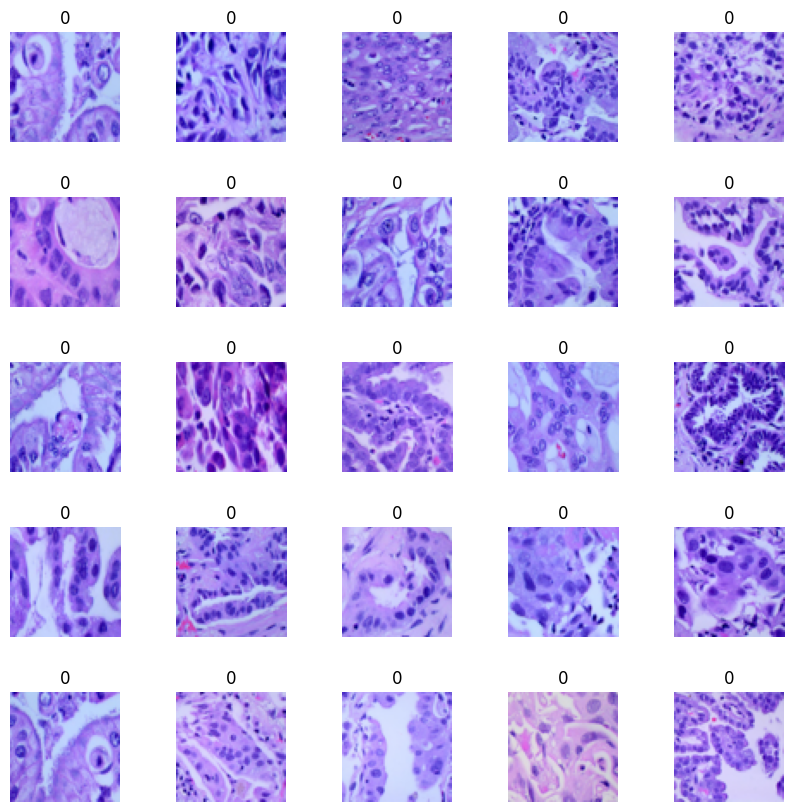

In [3]:
x0 = np.load('test_class0.npy')
x1 = np.load('test_class1.npy')
x2 = np.load('test_class2.npy')
x = np.concatenate((x0,x1, x2))

y0 = np.zeros(len(x0))
y1 = np.ones(len(x1))
y2 = np.full(len(x2), 2)

y = np.concatenate((y0,y1,y2))
y = y.astype(dtype=np.int64)

def plot_digits(x, y):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i], cmap='gray')
        ax.set_title(str(y[i]))
        ax.axis('off')

    plt.show()

plot_digits(x[:25], y[:25])

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset,DataLoader

class MyDataset(Dataset):

    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return (image, label)
        
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
     transforms.RandomChoice([
         transforms.RandomApply([transforms.RandomRotation(180)], p=0.05),
         transforms.RandomHorizontalFlip(0.05),
         transforms.RandomVerticalFlip(0.05),
         transforms.RandomApply([transforms.RandomResizedCrop(64)], p=0.05)])])

batch_size = 64

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25)
    
train = MyDataset(x_train, y_train, transform)
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
val = MyDataset(x_val, y_val, transform)
valloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(256*6*6, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 11)
        self.norm1 = nn.BatchNorm2d(16)
        self.norm2 = nn.BatchNorm2d(32)
        self.norm3 = nn.BatchNorm2d(64)
        self.norm4 = nn.BatchNorm2d(128)
        self.norm5 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout2d(0.30)
        self.dropout2 = nn.Dropout2d(0.30)
        self.dropout3 = nn.Dropout2d(0.20)
        self.dropout4 = nn.Dropout2d(0.15)
        self.dropout5 = nn.Dropout2d(0.15)
        self.dropout6 = nn.Dropout2d(0.10)
        self.padding2 = nn.ZeroPad2d(2)
        self.padding8 = nn.ZeroPad2d(8)

    def forward(self, x):
        x = self.pool(F.relu(self.dropout1(self.norm1(self.conv1(x)))))
        x = self.pool(F.relu(self.dropout2(self.norm2(self.conv2(x)))))
        x = self.pool(F.relu(self.dropout3(self.norm3(self.conv3(x)))))
        x = self.pool(F.relu(self.dropout4(self.norm4(self.conv4(self.padding8(x))))))
        x = self.pool(F.relu(self.dropout5(self.norm5(self.conv5(self.padding2(x))))))
        x = x.view(-1, 256*6*6)
        x1 = F.relu(self.fc1(x))
        x2 = F.relu(self.fc2(x1))
        x = self.dropout6(x1 + x2)
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-3)
loss_arr = []
loss_val_arr = []
acc = []
acc_val = []
epochs = 50
best_acc = 99
cur = 0
cur_loss = 10
best_loss = 10


for epoch in range(epochs):

    # x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25)
    
    # train = MyDataset(x_train, y_train, transform)
    # trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
    #                                           shuffle=True, num_workers=0)
    # val = MyDataset(x_val, y_val, transform)
    # valloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
    #                                           shuffle=True, num_workers=0)
    

    running_loss = 0.0
    running_loss_val = 0.0
    correct = 0
    total = 0
    correct_val = 0
    total_val = 0

    net.train()
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num = int(len(x_train)//batch_size)
        if i % num == num - 1:
            print('[%d, %5d] Train loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num),'\tAccuracy is:', 100 * correct / total,'%')
            loss_arr.append(running_loss / num)
            acc.append(100 * correct / total)
            if 100 * correct / total>cur:
                cur = 100 * correct / total
            running_loss = 0.0

    net.eval()
    for i, data in enumerate(valloader, 0):
        with torch.no_grad():
            images, labels = data[0].to(device), data[1].to(device)

            outputs = net(images)            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            loss_val = criterion(outputs, labels)
            running_loss_val += loss_val.item()
            num = int(len(x_val)//batch_size)
            if i % num == num - 1:
                print('[%d, %5d] Valid loss: %.3f' %
                      (epoch + 1, i + 1, running_loss_val / num),'\tAccuracy is:', 100 * correct_val / total_val,'%')
                loss_val_arr.append(running_loss_val / num)
                acc_val.append(100 * correct_val / total_val)
                cur_loss = running_loss_val / num
                running_loss_val = 0.0


    # if cur_loss<best_loss:
    #     optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=[0.999,0.999], weight_decay=1e-2)
    #     best_loss = cur_loss
    # else:
    #     optimizer = optim.Adam(net.parameters(), lr=0.001, betas=[0.9,0.999], weight_decay=1e-3)


print('Finished Training')

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[1,   175] Train loss: 0.541 	Accuracy is: 78.54464285714286 %
[1,    58] Valid loss: 0.366 	Accuracy is: 85.77586206896552 %
[2,   175] Train loss: 0.348 	Accuracy is: 86.36607142857143 %
[2,    58] Valid loss: 0.380 	Accuracy is: 83.59375 %
[3,   175] Train loss: 0.298 	Accuracy is: 88.33928571428571 %
[3,    58] Valid loss: 0.265 	Accuracy is: 90.40948275862068 %
[4,   175] Train loss: 0.273 	Accuracy is: 89.625 %
[4,    58] Valid loss: 0.276 	Accuracy is: 87.8771551724138 %
[5,   175] Train loss: 0.260 	Accuracy is: 90.03571428571429 %
[5,    58] Valid loss: 0.296 	Accuracy is: 87.68857758620689 %
[6,   175] Train loss: 0.246 	Accuracy is: 90.67857142857143 %
[6,    58] Valid loss: 0.182 	Accuracy is: 93.15732758620689 %
[7,   175] Train loss: 0.246 	Accuracy is: 90.52678571428571 %
[7,    58] Valid loss: 0.274 	Accuracy is: 89.84375 %
[8,   175] Train loss: 0.230 	Accuracy is: 91.17857142857143 %
[8,    58] Valid loss: 0.223 	Accuracy is: 90.94827586206897 %
[9,   175] Train loss:

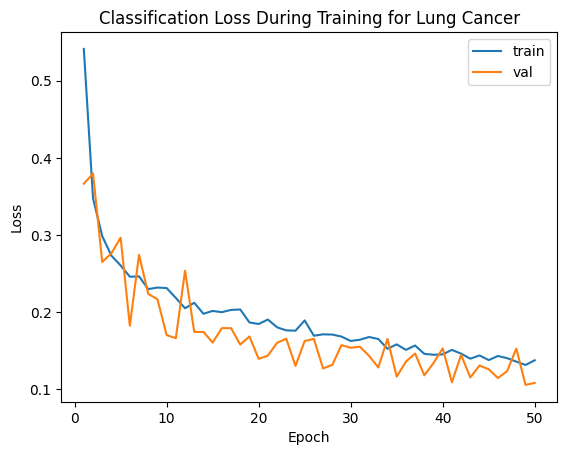

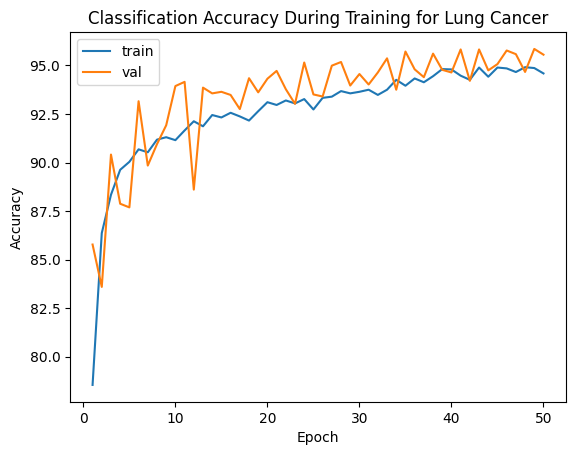

In [5]:
plt.plot(np.arange(epochs)+1,loss_arr,label='train')
plt.plot(np.arange(epochs)+1,loss_val_arr,label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Loss During Training for Lung Cancer')
plt.show()

plt.plot(np.arange(epochs)+1,acc,label='train')
plt.plot(np.arange(epochs)+1,acc_val,label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy During Training for Lung Cancer')
plt.show()

In [6]:
x0_test = np.load('test_class0.npy')
x1_test = np.load('test_class1.npy')
x2_test = np.load('test_class2.npy')
x_test = np.concatenate((x0_test,x1_test, x2_test))
y0_test = np.zeros(len(x0_test))
y1_test = np.ones(len(x1_test))
y2_test = np.full(len(x2), 2)
y_test = np.concatenate((y0_test,y1_test, y2_test))
y_test = y_test.astype(dtype=np.int64)


In [7]:
correct = 0
total = 0
test = MyDataset(x_test, y_test, transform)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
y_hat = []
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(len(predicted)):
            y_hat.append(predicted[i].item())

print('Accuracy is:',
    100 * correct / total,'%')

Accuracy is: 96.82 %


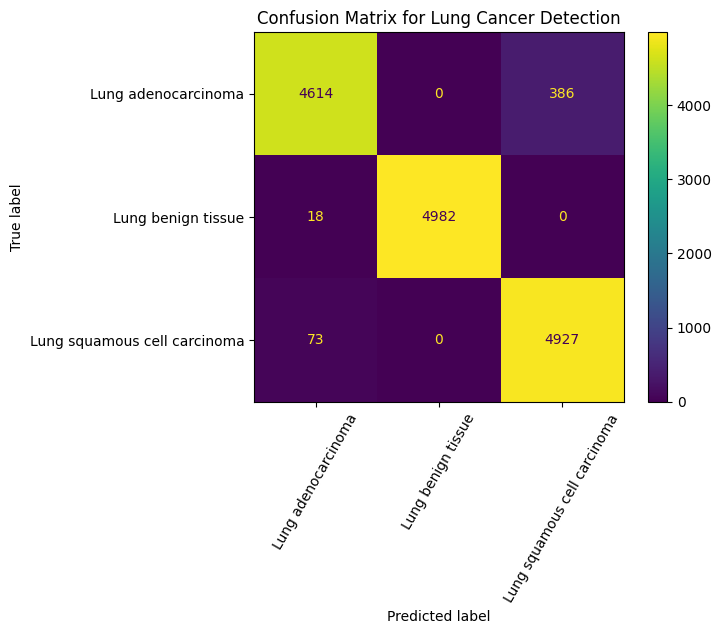

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_hat, display_labels=['Lung adenocarcinoma', 'Lung benign tissue', 'Lung squamous cell carcinoma'])
plt.title("Confusion Matrix for Lung Cancer Detection")
plt.xticks(rotation=60)
plt.show()

{'Lung adenocarcinoma': {'precision': 0.9806588735387886, 'recall': 0.9228, 'f1-score': 0.9508500772797528, 'support': 5000}, 'Lung benign tissue': {'precision': 1.0, 'recall': 0.9964, 'f1-score': 0.9981967541574834, 'support': 5000}, 'Lung squamous cell carcinoma': {'precision': 0.9273480143045361, 'recall': 0.9854, 'f1-score': 0.955493067002812, 'support': 5000}, 'accuracy': 0.9682, 'macro avg': {'precision': 0.9693356292811082, 'recall': 0.9682000000000001, 'f1-score': 0.9681799661466828, 'support': 15000}, 'weighted avg': {'precision': 0.9693356292811082, 'recall': 0.9682, 'f1-score': 0.9681799661466828, 'support': 15000}}


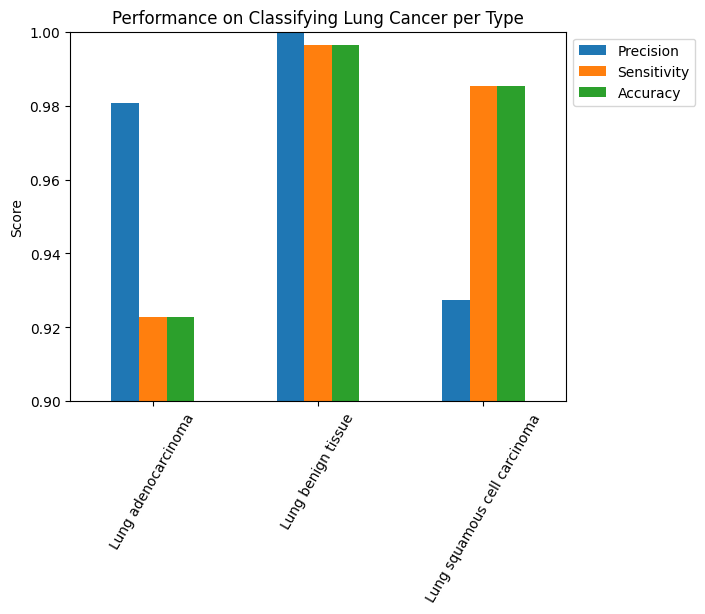

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

cm = confusion_matrix(y_test, y_hat)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

report = classification_report(y_test, y_hat, target_names=['Lung adenocarcinoma', 'Lung benign tissue', 'Lung squamous cell carcinoma'], output_dict=True)
print(report)

df = pd.DataFrame(report).transpose()
df = df.rename(columns={'precision': 'Precision', 'recall': 'Sensitivity'}) 
df = df[~df.index.isin(['accuracy', 'macro avg', 'weighted avg'])]

df_final = df.drop(columns=['support', 'f1-score'])
df_final['Accuracy'] = cm.diagonal()

df_final.plot(kind='bar')

plt.title("Performance on Classifying Lung Cancer per Type")
plt.ylabel("Score")
plt.xticks(rotation=60)
plt.ylim(0.9,1)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [10]:
def specificity(conf_matrix):
    specificities = []
    for i in range(len(conf_matrix)):
        TN = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
        FP = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
        specificity = TN / (TN + FP)
        specificities.append(specificity)
    return specificities

# Example usage:
specificities = specificity(cm)
print("Specificities per class:", specificities)
np.mean(specificities)

Specificities per class: [0.9909000000000001, 1.0, 0.9614000000000001]


0.9841000000000001

# SAM Integration for Lung

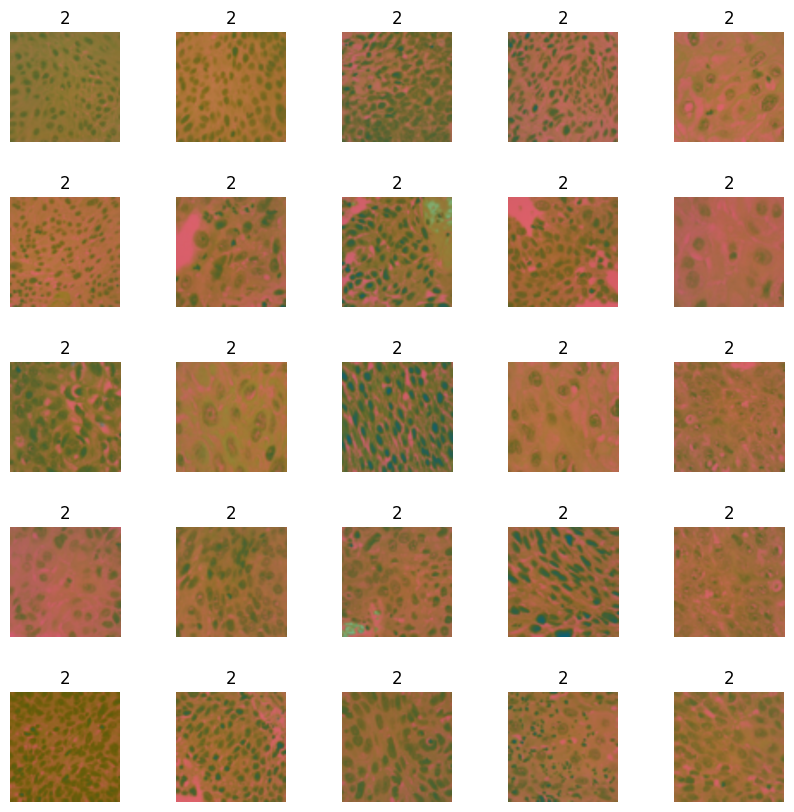

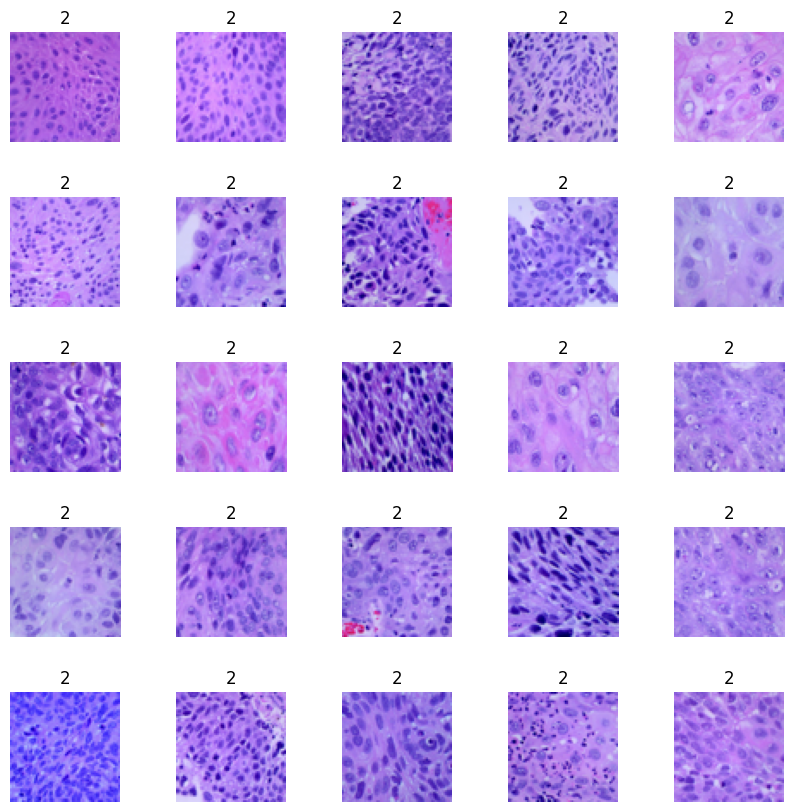

In [11]:
import cv2

images_rgb = x
images_luv = []

for i in images_rgb:
    #images_luv.append(cv2.cvtColor(i, cv2.COLOR_RGB2Luv))
    images_luv.append(cv2.cvtColor(cv2.resize(i, (256,256)), cv2.COLOR_RGB2Luv))
images_luv = np.array(images_luv)
plot_digits(images_luv[-25:], y[-25:])
plot_digits(x[-25:], y[-25:])

In [12]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam = sam_model_registry['vit_h'](checkpoint=r'/kaggle/input/sam-pretrained-for-medical-image/pytorch/default/1/sam_vit_h_4b8939.pth').to(device)
sam.mask_decoder.iou_prediction_head.layers[2].out_features = 2
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam, pred_iou_thresh=0.9, output_mode='binary_mask', stability_score_thresh=0.9)

/opt/conda/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [13]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [14]:
sam_list = []
sam_list.append(mask_generator.generate(images_luv[-7].astype(np.uint8)))
# for i in images_luv:
#     sam_list.append(mask_generator.generate(i.astype(np.uint8)))
print(sam_list[0][0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


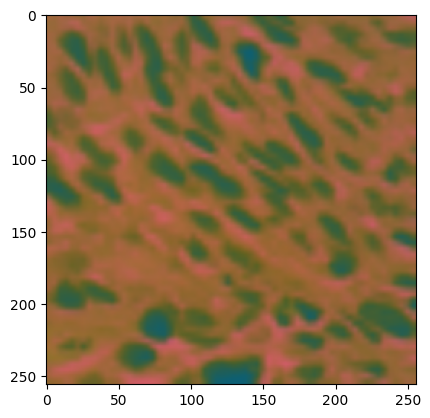

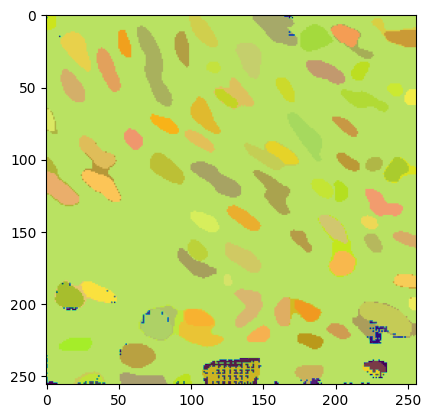

In [15]:
plt.imshow(images_luv[-7])
plt.show()
plt.imshow(sam_list[0][0]['segmentation'])
show_anns(sam_list[0])

In [16]:
# show 5 from label 0 and 5 from label 2!!!
# want title to be: Segmentation Example of Cancerous Lung Tissue (Type)